In [1]:
import ROOT
import seaborn as sns
import pandas as pd
import numpy as np
import subprocess
from multiprocessing import Pool

Welcome to JupyROOT 6.30/08


In [2]:
folder = "/lustre/r3b/ywang/test/first_hit"
channels = ["tamex", "tacquila", "mock"]
paddles = ["neuland", "mock"]
event_number = 100000

def get_filename(paddle, channel):
    return f"digi_{paddle}_paddle_{channel}_channel.root"
    
def get_logfilename(paddle, channel):
    return f"digi_{paddle}_paddle_{channel}_channel.log"

def neuland_ana(paddle, channel):
    filename = get_filename(paddle, channel)
    logfilename = get_logfilename(paddle, channel)
    with open(f"{folder}/{logfilename}", "w") as f:
        subprocess.call(
            f"neulandAna --digiFile {folder}/{filename} --paddle '{paddle}' --channel '{channel}' --simuFile {folder}/simu.root --paraFile {folder}/para.root",
            shell = True, stdout = f, stderr = f)
    # !neulandAna --digiFile "{folder}/{filename}" --paddle {paddle} --channel {channel}

In [3]:
# !neulandSim --eventNum {event_number} --eventPrint {event_number//10} --simuFile {folder}/simu.root --paraFile {folder}/para.root
with Pool(99) as p:
    p.starmap(neuland_ana, [(paddle, channel) for channel in channels for paddle in paddles])

In [4]:
# folder = "/lustre/land/ilihtar/neuland/sim_August24"
# digi_file_name = "digi1n_phasespace_25MeV_thresh0.root"
# simu_file_name = "sim1n_phasespace_25MeV.root"
simu_file_name = "simu.root"
digi_filenames = [(paddle, channel, get_filename(paddle, channel)) for paddle in paddles for channel in channels]
point_branches = ["NeulandPoints.fTime", "NeulandPoints.fDetectorID"]
hit_branches = ["NeulandHits.fT", "NeulandHits.fPaddle"]


In [5]:
def create_data_frame(folder, filename, branches, paddle_label = None, channel_label = None, simu_dataframe = pd.DataFrame()):
    root_file = ROOT.TFile(f"{folder}/{filename}")
    data_arrays = ROOT.RDataFrame("evt", root_file).AsNumpy(branches)
    
    event_size = len(data_arrays[branches[0]])
    times = np.zeros(event_size, dtype = 'float32')
    plane_ids = np.zeros(event_size, dtype = 'int') # starts from 0
    times[:] = np.nan
    plane_ids[:] = -1
    
    event_index = 0
    for fTs, paddleNums in zip(data_arrays[branches[0]], data_arrays[branches[1]]):
        if len(fTs) != 0:
            fT_min, paddle_num = min(zip(fTs, paddleNums), key = lambda x: x[0])
            times[event_index] = fT_min
            plane_ids[event_index] = (paddle_num - 1) // 50
        event_index += 1
    data_frame = pd.DataFrame({"plane_id": plane_ids, "times": times}).dropna()
    if not simu_dataframe.empty:
        new_simu = simu_dataframe.copy()
        new_simu["level"] = "points"
        data_frame["level"] = "hits"
        data_frame = pd.concat([data_frame, new_simu])
    if paddle_label != None:
        data_frame["paddle"] = paddle_label
    if channel_label != None:
        data_frame["channel"] = channel_label
    return data_frame

In [6]:
simu = create_data_frame(folder, simu_file_name, point_branches)
dataframes = [create_data_frame(folder, filename, hit_branches, paddle, channel, simu) for paddle, channel, filename in digi_filenames]

Warning in <TStreamerInfo::BuildCheck>: 
   The StreamerInfo of class R3BMCTrack read from file /lustre/r3b/ywang/test/first_hit/simu.root
   has the same version (=3) as the active class but a different checksum.
   You should update the version to ClassDef(R3BMCTrack,4).
   Do not try to write objects with the current class definition,
   the files will not be readable.

Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 3 of class 'R3BMCTrack' differs from 
the in-memory layout version 3:
   int fNPoints; //
vs
   array<int,52> fNPoints; //


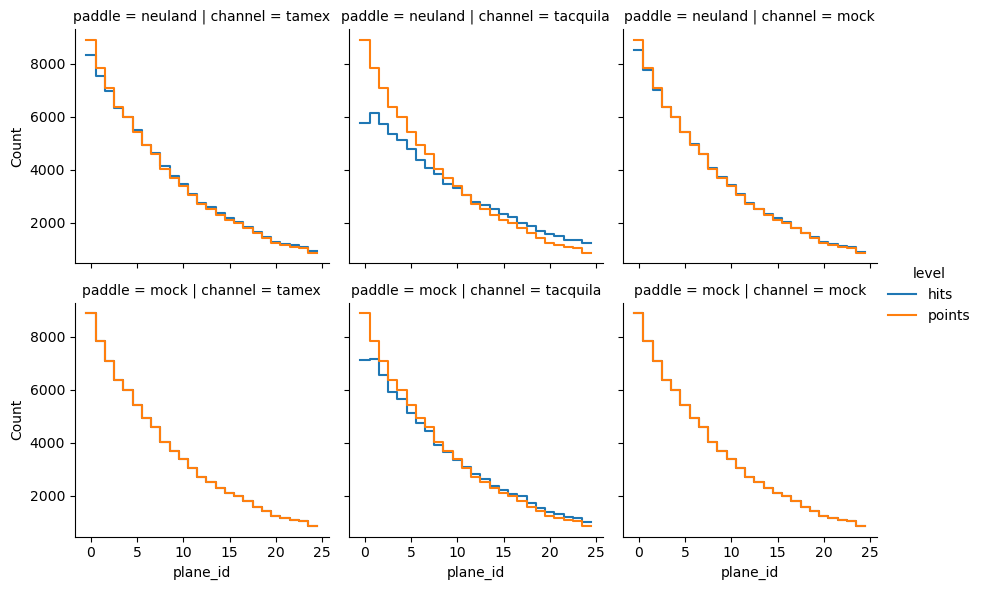

In [7]:

plane_id_compare = pd.concat(dataframes)

graphs = sns.FacetGrid(plane_id_compare, col = "channel", row = "paddle", hue = "level")
graphs.map_dataframe(sns.histplot, x = "plane_id", binwidth = 1, binrange = [-0.5, 24.5], element="step", fill = False)
graphs.add_legend()